In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

## Review: Components We've Built

Recall from previous sections:
- **Attention (Section 03):** scaled dot-product attention, multi-head attention, self-attention
- **FFN & Norms (Section 04):** position-wise FFN, LayerNorm, residual connections

Now we combine them into a reusable encoder block.

In [2]:
# Quick implementations (recap from earlier sections)
import json
import math
from typing import Optional

# Load real English-Farsi translation data
with open('../.data/en_fa_train.jsonl', 'r', encoding='utf-8') as f:
    samples = [json.loads(line) for line in f]

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Compute scaled dot-product attention."""
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores + mask
    attn = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)
    return out, attn

class SimpleMultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.Wq = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wk = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wv = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wo = torch.nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x):
        seq_len = x.shape[0]
        x = x.view(seq_len, self.num_heads, self.d_head).transpose(0, 1)
        return x

    def combine_heads(self, x):
        x = x.transpose(0, 1).contiguous()
        seq_len = x.shape[0]
        return x.view(seq_len, self.d_model)

    def forward(self, x, mask=None):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)
        out_heads = []
        attn_heads = []
        for i in range(self.num_heads):
            out_i, attn_i = scaled_dot_product_attention(Qh[i], Kh[i], Vh[i], mask)
            out_heads.append(out_i)
            attn_heads.append(attn_i)
        out = torch.stack(out_heads, dim=0)
        out_combined = self.combine_heads(out)
        return self.Wo(out_combined), attn_heads

class SimpleLayerNorm(torch.nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(d_model))
        self.beta = torch.nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

class SimpleFFN(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation='gelu'):
        super().__init__()
        self.W1 = torch.nn.Linear(d_model, d_ff)
        self.W2 = torch.nn.Linear(d_ff, d_model)
        self.activation = activation

    def gelu(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

    def forward(self, x):
        if self.activation == 'gelu':
            hidden = self.gelu(self.W1(x))
        else:
            hidden = torch.relu(self.W1(x))
        return self.W2(hidden)

class EncoderBlock(torch.nn.Module):
    """
    Single transformer encoder block: MultiHeadAttention -> Add & Norm -> FFN -> Add & Norm
    """
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = SimpleMultiHeadAttention(d_model, num_heads)
        self.ln1 = SimpleLayerNorm(d_model)
        self.ffn = SimpleFFN(d_model, d_ff)
        self.ln2 = SimpleLayerNorm(d_model)

    def forward(self, x, mask=None):
        # x: (seq_len, d_model)
        attn_out, attn_weights = self.attn(x, mask=mask)
        x = x + attn_out
        x = self.ln1(x)
        ffn_out = self.ffn(x)
        x = x + ffn_out
        x = self.ln2(x)
        return x, attn_weights

print("Components loaded: MultiHeadAttention, LayerNorm, FFN, EncoderBlock")

Components loaded: MultiHeadAttention, LayerNorm, FFN, EncoderBlock


## EncoderBlock: Combining All Components

An encoder block combines:
1. **Attention branch:** LayerNorm → MultiHeadAttention → Residual
2. **FFN branch:** LayerNorm → FFN → Residual

This is the "Pre-Norm" design where normalization happens before each sublayer.

In [7]:
# Demo: single encoder block on real text embeddings
from transformers import AutoTokenizer, AutoModel

# Get real embeddings from a longer sentence
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

# Combine first 3 English sentences from dataset for a longer sequence
text = ' '.join([samples[i]['input'] for i in range(3)])
tokens = tokenizer(text, return_tensors='pt')
words = tokenizer.tokenize(text)

with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)
    embeddings = outputs.last_hidden_state[0]  # (seq_len, 768)

d_model = embeddings.shape[1]  # 768
num_heads = 8
d_ff = d_model * 4

# Create and apply encoder block
block = EncoderBlock(d_model, num_heads, d_ff)
output, attn_weights = block(embeddings)

print(f"Text: {text}")
print(f"Number of tokens: {len(words)}")
print(f"Input shape: {embeddings.shape} (embeddings from pretrained model)")
print(f"Output shape: {output.shape}")
print(f"Number of attention heads: {len(attn_weights)}")
print(f"\nThe encoder block refined the embeddings by:")
print(f"  1. Computing self-attention across all {len(words)} tokens")
print(f"  2. Applying a feed-forward network to each token")
print(f"  3. Using residual connections to preserve information")

Text: I invited my foolish friend Jay around for tennis because I thought he'd make me look good. Pack your stuff. Aunt Silvy, stop yelling!
Number of tokens: 32
Input shape: torch.Size([34, 768]) (embeddings from pretrained model)
Output shape: torch.Size([34, 768])
Number of attention heads: 8

The encoder block refined the embeddings by:
  1. Computing self-attention across all 32 tokens
  2. Applying a feed-forward network to each token
  3. Using residual connections to preserve information


## Encoder: Stacking Blocks

A full encoder consists of multiple stacked encoder blocks. Each block refines the representations.

In [4]:
class SimpleEncoder(torch.nn.Module):
    """
    Stack of encoder blocks.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers):
        super().__init__()
        self.blocks = torch.nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        """
        x: (seq_len, d_model)
        Returns: (seq_len, d_model) and list of attention weights per layer
        """
        all_attn = []
        for block in self.blocks:
            x, attn = block(x, mask=mask)
            all_attn.append(attn)
        return x, all_attn

# Demo: full encoder stack on the real embeddings from before
num_layers = 3
encoder = SimpleEncoder(d_model, num_heads, d_ff, num_layers)

# Use the embeddings from the previous cell (combined sentences)
output, layer_attentions = encoder(embeddings)

print(f"Input text: {text}")
print(f"Input shape: {embeddings.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of encoder layers stacked: {num_layers}")
print(f"Attention maps per layer: {len(layer_attentions[0])} heads")
print(f"\nEach of the {num_layers} layers refined the representations further,")
print(f"building deeper contextual understanding of the {len(words)} tokens.")

Input text: I invited my foolish friend Jay around for tennis because I thought he'd make me look good. Pack your stuff. Aunt Silvy, stop yelling!
Input shape: torch.Size([34, 768])
Output shape: torch.Size([34, 768])
Number of encoder layers stacked: 3
Attention maps per layer: 8 heads

Each of the 3 layers refined the representations further,
building deeper contextual understanding of the 32 tokens.


## How Information Flows

Visualize how attention patterns change across encoder layers. Each layer refines what the model "attends to."

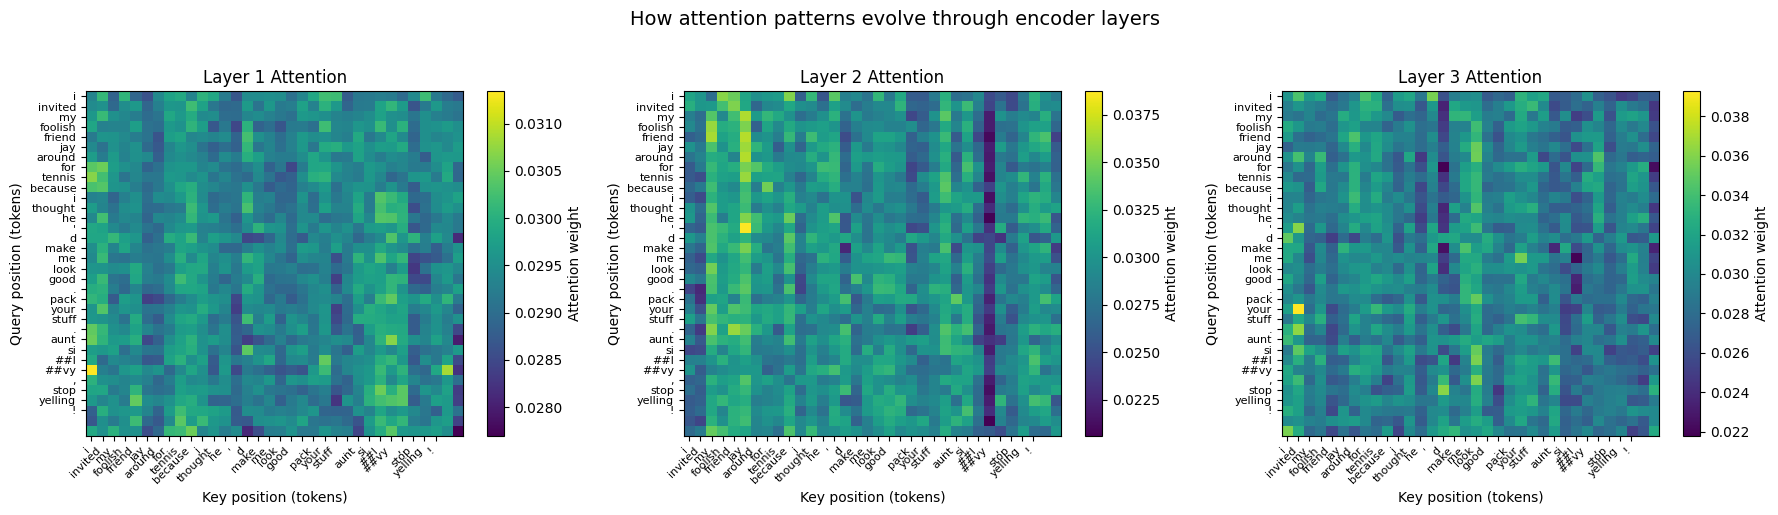

Observation: As you go deeper through encoder layers, attention patterns become more refined.
Early layers might focus on local word relationships, deeper layers capture semantic dependencies.


In [5]:
# Visualize attention evolution across layers on our real text
fig, axes = plt.subplots(1, num_layers, figsize=(18, 5))

for layer_idx, attn_heads in enumerate(layer_attentions):
    # Average attention across heads to get a single (seq_len, seq_len) map
    avg_attn = torch.stack(attn_heads, dim=0).mean(dim=0)
    
    ax = axes[layer_idx]
    im = ax.imshow(avg_attn.detach().numpy(), cmap='viridis', aspect='auto')
    ax.set_xlabel('Key position (tokens)')
    ax.set_ylabel('Query position (tokens)')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=8)
    ax.set_title(f'Layer {layer_idx + 1} Attention')
    plt.colorbar(im, ax=ax, label='Attention weight')

plt.suptitle('How attention patterns evolve through encoder layers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: As you go deeper through encoder layers, attention patterns become more refined.")
print("Early layers might focus on local word relationships, deeper layers capture semantic dependencies.")


## Comparison with Hugging Face

Show how a real encoder (from `transformers`) follows the same pattern.

Text: I invited my foolish friend Jay around for tennis because I thought he'd make me look good.
Model has 6 encoder layers
Input tokens: ['[CLS]', 'i', 'invited', 'my', 'foolish', 'friend', 'jay', 'around', 'for', 'tennis', 'because', 'i', 'thought', 'he', "'", 'd', 'make', 'me', 'look', 'good', '.', '[SEP]'] (seq_len=22)
Final hidden state shape: torch.Size([1, 22, 768])


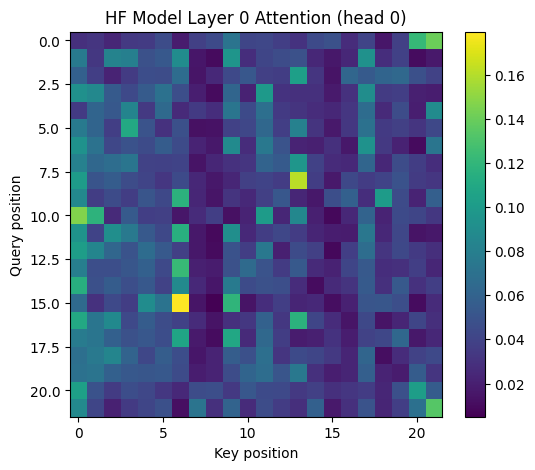


Our from-scratch encoder and this HF model both stack blocks and learn contextual representations!


In [8]:
from transformers import AutoTokenizer, AutoModel

# Load a pre-trained encoder (BERT-like)
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

text = samples[0]['input']
enc = tokenizer(text, return_tensors='pt')

with torch.no_grad():
    outputs = model(**enc, output_hidden_states=True)
    # outputs.attentions: tuple of (num_layers, batch=1, num_heads, seq_len, seq_len)
    # outputs.hidden_states: tuple of (num_layers+1, batch, seq_len, d_model)

print(f"Text: {text}")
print(f"Model has {len(outputs.attentions)} encoder layers")
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(enc['input_ids'][0])} (seq_len={enc['input_ids'].shape[1]})")
print(f"Final hidden state shape: {outputs.hidden_states[-1].shape}")

# Visualize attention from layer 0
layer0_attn = outputs.attentions[0][0, 0].numpy()  # layer 0, batch 0, head 0
plt.figure(figsize=(6, 5))
plt.imshow(layer0_attn, cmap='viridis', aspect='auto')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.title('HF Model Layer 0 Attention (head 0)')
plt.colorbar()
plt.show()

print(f"\nOur from-scratch encoder and this HF model both stack blocks and learn contextual representations!")
